## Exploratory Data Analysis: examining the dataset

This report is based on my project workflow and covers Framing, Preparing and work to date Analysing the data.
- Frame: Develop a hypothesis-driven approach to the analysis.
- Prepare: Select, import, explore, and clean the data.
- Analyse: Structure, visualise, and complete the analysis.
- Interpret: Derive recommendations and investment or risk decisions from the data.
- Communicate: Present (edited) insights from the data to different audiences.

## Cold Climate Humanitarian Shelter

### Framing 
##### Problem statement: 
- uncomfortable and unhealthy indoor conditions in temporary shelters during the winter can have an impact on mortality and morbidity of displaced people and refugees.
- fuel is needed to maintain warm temperatures but burning fuel, especially overnight, creates a fire hazard and exposes occupants to high concentrations of harmful indoor air pollutants
- the ability to monitor internal temperatures and to understand the thermal properties of shelters in use would support targeted and timely health interventions and inform design improvements to shelter

##### Hypotheses and Predictions:
#It is possible to estimate:
1. internal mean temperature, given the heat input, external temperature and temperature(s) in previous timesteps
2. predict heat input required to maintain a constant internal temperature given external conditions
3. predict internal temperature differences (stratification) given the heat input, external temperature and temperature(s) in previous timesteps

#It is possible to estimate:
4. an indicator (i.e. coefficient) that represents the thermal properties of a humanitarian shelter given the internal time-temperature response, external temperature and heat input

#It is possible to visualize data in a way that supports design and priorities:
5. plot cold and hot zones

### Data Audit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates
import datetime

%matplotlib inline


In [2]:
# EOD task: import, clean and rename all data sheets
test_names = ['Exp_1/DAT26NOV.csv','Exp_1/DAT29NOV.csv','Exp_1/DAT30NOV.csv','Exp_1/DAT1DEC.csv','Exp_1/DAT2DEC.csv','Exp_1/DAT3DEC.csv']
namespace99 = globals()
df_names = []
humidity_only_columns = ['Times','C_021', 'C_022', 'C_023', 'C_024', 'C_026', 'C_027', 'C_028', 'C_029',
       'C_030', 'C_031', 'C_032', 'C_033', 'C_034', 'C_035']
temperature_only_columns = ['Times', 'C_036', 'C_037', 'C_038', 'C_039', 'C_040', 'C_041', 'C_042', 'C_043',
       'C_044', 'C_045', 'C_046', 'C_047', 'C_048', 'C_049', 'C_050', 'C_051',
       'C_052', 'C_053', 'C_054', 'C_055', 'C_056', 'C_057', 'C_058', 'C_059',
       'C_060']
start_dates = ['1999-11-26','1999-11-29','1999-11-30','1999-12-01','1999-12-02','1999-12-03']
for index, name in enumerate(test_names):
    #print(name)
    #print(index)
    namespace99["all_%s"% str(index)] = pd.read_csv(str(name),skiprows=8)
    df_names.append(str("all_%s"% str(index)))
    namespace99["all_%s"% str(index)]['Times'] = pd.to_datetime(namespace99["all_%s"% str(index)]["Times"], format="%H:%M:%S")
    start_date = pd.Timestamp(start_dates[index]).strftime('%Y-%m-%d')
    namespace99["all_%s"% str(index)]["Times"] = pd.to_datetime(start_date + ' '  + namespace99["all_%s"% str(index)]['Times'].astype(str))
    namespace99["hum_%s"% str(index)] = namespace99["all_%s"% str(index)][humidity_only_columns] 
    namespace99["temp_%s"% str(index)] = namespace99["all_%s"% str(index)][temperature_only_columns] 
hum_0.head(3)


,Times,C_021,C_022,C_023,C_024,C_026,C_027,C_028,C_029,C_030,C_031,C_032,C_033,C_034,C_035
0,1999-11-26 09:54:35,2.8432,2.0624,3.4141,0.58010,3.7521,3.8001,1.700000e-06,2.9746,2.0474,3.4367,2.1041,2.0849,2.8790,3.8568
1,1999-11-26 10:09:35,4.9593,3.1708,5.5012,0.91549,5.2516,3.0817,1.000000e-07,5.6545,3.2308,5.5677,3.4750,3.0417,5.3662,5.9277
2,1999-11-26 10:24:35,5.5478,4.6878,5.7091,1.39740,5.6688,5.8366,1.800000e-06,5.8374,5.2160,5.9214,5.5118,4.9800,5.8112,6.1680


In [3]:
# read in the sensor index
sensors_index = pd.read_csv('sensors_index.csv')
sensors_index.head(3)
sensors_index.drop('Unnamed: 0',axis=1)

,sensor,type,sensing,y_slice,x_slice,z_slice,v_ref1,v_ref2,v_ref3,x_coord,y_coord,z_coord,slopes,intercepts
0,C_021,hum,air,front,left,low,5.78350,0.9261,0.8727,0.45,0.45,0.150000,-15.485477,97.471845
1,C_022,hum,air,front,left,middle,6.41980,0.8606,0.8404,0.45,0.45,1.050000,-13.564631,95.051885
2,C_023,hum,air,front,centre,low,6.54630,0.9162,0.8869,1.80,0.45,0.150000,-13.386714,95.590343
3,C_024,hum,air,front,centre,middle,6.42700,0.9003,0.8656,1.80,0.45,1.050000,-13.632197,95.562409
4,C_025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,C_026,hum,air,front,centre,high,6.60250,0.9041,0.8517,1.80,0.45,1.500000,-13.208251,95.132842
6,C_027,hum,air,front,right,low,5.05980,0.1518,0.2123,3.15,0.45,0.150000,-15.444245,86.256014
7,C_028,hum,air,front,right,middle,6.35860,0.8704,0.8416,3.15,0.45,1.050000,-13.732632,95.276859
8,C_029,hum,air,back,left,low,6.68915,0.8901,0.8457,0.45,3.15,0.150000,-12.985862,94.801746
9,C_030,hum,air,back,left,middle,6.65520,0.8708,0.8991,0.45,3.15,1.050000,-13.073282,95.047904


In [4]:
# create sensor lists by type
humidity = []
temperature = []
for idx,val in sensors_index.iterrows():
    if val[2] == 'hum':
     #   print(val[1])
        humidity.append(val[1])
    elif val[2] == 'temp':
     #   print(val[1])
        temperature.append(val[1])

In [5]:
#run humidity correction on all columns in one data frame

for idx,val in sensors_index.iterrows():
    if val[2] =='hum':
        x = val[1] #sensor name
        y = val[13] #calibration gradient
        z = val[14]  #calibration intercept      
            #print(x,y,z)
        namespace99["adj_%s"% str(val[1])] = [] #named for new column
        for i in all_1[val[1]]: #for each row of each sensor column adjust humidity 
            corrected = (i * val[13]) + z
                #print(corrected)
            namespace99["adj_%s"% str(val[1])].append(corrected) #fill list with adjusted values
        all_1[str("adj_%s"% str(val[1]))] = namespace99["adj_%s"% str(val[1])]


In [6]:
#run humidity correction on all columns in all data frames
for index, name in enumerate(df_names):
    for idx,val in sensors_index.iterrows():
        if val[2] =='hum':
            x = val[1] #sensor name
            y = val[13] #calibration gradient
            z = val[14]  #calibration intercept      
            #print(x,y,z)
            namespace99["adj_%s"% str(val[1])] = [] #named for new column
            for i in namespace99["all_%s"% str(index)][val[1]]: #for each row of each sensor column adjust humidity 
                corrected = (i * val[13]) + z
                #print(corrected)
                namespace99["adj_%s"% str(val[1])].append(corrected) #fill list with adjusted values
            namespace99["all_%s"% str(index)][str("adj_%s"% str(val[1]))] = namespace99["adj_%s"% str(val[1])]

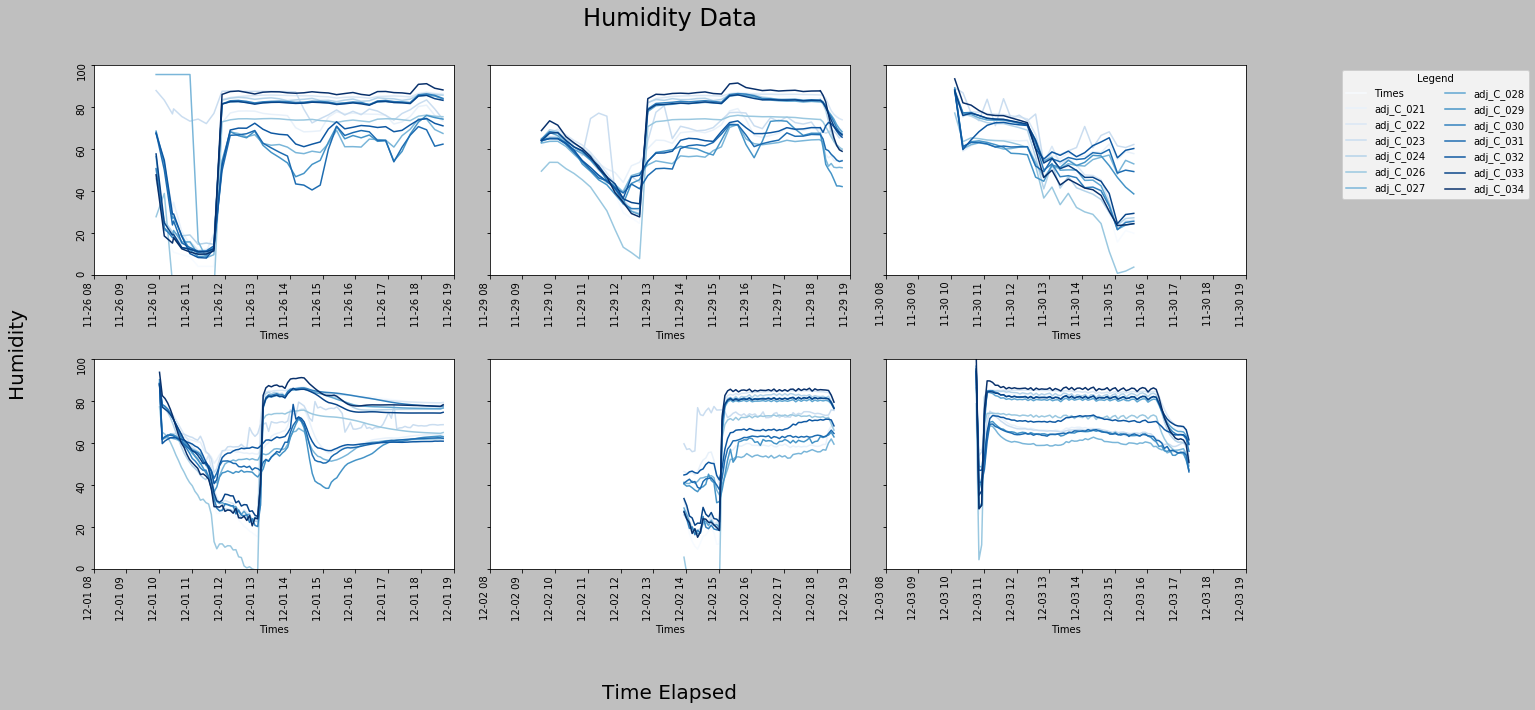

In [9]:
# HUMIDITY-CORRECTED ALL PLOTS
hum_features = ['Times','adj_C_021', 'adj_C_022', 'adj_C_023', 'adj_C_024',
       'adj_C_026', 'adj_C_027', 'adj_C_028', 'adj_C_029', 'adj_C_030',
       'adj_C_031', 'adj_C_032', 'adj_C_033', 'adj_C_034', 'adj_C_035']
#fig = plt.figure()
fig, axes = plt.subplots(2, 3,sharey=True,figsize=(20,10))
plt.style.use('grayscale')
fig = plt.gcf()
all_0[hum_features].plot(kind='line',x='Times',ax=axes[0,0],legend=False,cmap='Blues')
all_1[hum_features].plot(kind='line',x='Times',ax=axes[0,1],legend=False,cmap='Blues')
all_2[hum_features].plot(kind='line',x='Times',ax=axes[0,2],legend=False,cmap='Blues')
all_3[hum_features].plot(kind='line',x='Times',ax=axes[1,0],legend=False,cmap='Blues')
all_4[hum_features].plot(kind='line',x='Times',ax=axes[1,1],legend=False,cmap='Blues')
all_5[hum_features].plot(kind='line',x='Times',ax=axes[1,2],legend=False,cmap='Blues')

axes[0,0].legend(ncol=2,  title="Legend", labels = hum_features, bbox_to_anchor=(4, 1))
layout = {
    'left'  : 0.1,  
    'right' : 0.9,    
    'bottom' : 0.2,   
    'top' : 0.9,      
    'wspace' : 0.1,   
    'hspace' : 0.4 
    }

plt.subplots_adjust(left=layout['left'], bottom=layout['bottom'], right=layout['right'], top=layout['top'], wspace=layout['wspace'], hspace=layout['hspace'])
fig.suptitle('Humidity Data', fontsize=24)
fig.text(0.5, 0.04, 'Time Elapsed', va='top', ha='center',fontsize=20)
fig.text(0.04, 0.5, 'Humidity', va='center', rotation='vertical',fontsize=20)
plt.ylim(0,100)
plt.rcParams["date.autoformatter.minute"] = '%H:%M'
axes[0,0].tick_params(rotation=90)
axes[0,1].tick_params(rotation=90)
axes[0,2].tick_params(rotation=90)
axes[1,0].tick_params(rotation=90)
axes[1,1].tick_params(rotation=90)
axes[1,2].tick_params(rotation=90)
axes[0,0].set_xlim(datetime.datetime(1999,11,26,8), datetime.datetime(1999,11,26,19))
axes[0,1].set_xlim(datetime.datetime(1999,11,29,8), datetime.datetime(1999,11,29,19))
axes[0,2].set_xlim(datetime.datetime(1999,11,30,8), datetime.datetime(1999,11,30,19))
axes[1,0].set_xlim(datetime.datetime(1999,12,1,8), datetime.datetime(1999,12,1,19))
axes[1,1].set_xlim(datetime.datetime(1999,12,2,8), datetime.datetime(1999,12,2,19))
axes[1,2].set_xlim(datetime.datetime(1999,12,3,8), datetime.datetime(1999,12,3,19))
fig.savefig('exp_01_humidity.png')

In [11]:
#run polarity correction on all data frames (see also reverse_polarity.ipynb)
# test temperature correction on one column
# method 1: make a dataframe of 10000 trial values
neg_range = {'C0': 0,
            'C1': 2.5173462 * 10**1,
            'C2': -1.1662878,
            'C3' : -1.0833638,
            'C4' : -8.9773540 * 10**-1,
            'C5' : -3.7342377 * 10**-1,
            'C6' : -8.6632643 * 10**-2,
            'C7' : -1.0450598 * 10**-2,
            'C8' : -5.1920577 * 10**-4,
            'C9' : 0
            }
pos_range = {'C0': 0,
            'C1' : 2.508355 * 10**1,
            'C2' : 7.860106 * 10**-2,
            'C3' : -2.503131 * 10**-1,
            'C4' : 8.315270 * 10**-2,
            'C5' : -1.228034 * 10**-2,
            'C6' : 9.804036 * 10**-4,
            'C7' : -4.413030 * 10**-5,
            'C8' : 1.057734 * 10**-6,
            'C9' : -1.052755 * 10**-8 
            }
start_v = -5
end_v = 20
voltage_table = [start_v]
temps_table = []
v_series = [0] * 10000
for i,v in enumerate(v_series):
    #print(i)
    inc = (i+1)*25/10000
    voltage_table.append(start_v + inc)
for i,v in enumerate(voltage_table):
    if v < 0:
        t = neg_range['C0'] + neg_range['C1']*v + neg_range['C2']*v**2 + neg_range['C3']*v**3 + neg_range['C4']*v**4 + \
        neg_range['C5']*v**5 + neg_range['C6']*v**6 + neg_range['C7']*v**7 + neg_range['C8']*v**8 +neg_range['C9']*v**9
    elif v > 0:
        t = pos_range['C0'] + pos_range['C1']*v + pos_range['C2']*v**2 + pos_range['C3']*v**3 + pos_range['C4']*v**4 + \
        pos_range['C5']*v**5 + pos_range['C6']*v**6 + pos_range['C7']*v**7 + pos_range['C8']*v**8 +pos_range['C9']*v**9
    else:
        t = 0
    temps_table.append(t)
df2 = pd.DataFrame({'voltages': voltage_table,'temps':temps_table})
df2.head(5)

for index, name in enumerate(df_names):
    #for one dataframe try a fix
    true_T_040 = namespace99["all_%s"% str(index)]['C_040']
    true_T_058 = namespace99["all_%s"% str(index)]['C_058']
    true_V = ['NA']*len(true_T_040)
    namespace99["est_C_040_%s"% str(index)] = []
    namespace99["est_C_058_%s"% str(index)] = []
    for i,v in enumerate(true_V):
        #print(true_T[i])
        error_C_040 = []
        error_C_058 = []
        for idx, val in df2.iterrows():
            error_C_040.append(abs(val[1] - true_T_040[i]))
            error_C_058.append(abs(val[1] - true_T_058[i]))
        df2[str("difference_C_040_%s"% str(index))] = error_C_040
        df2[str("difference_C_058_%s"% str(index))] = error_C_058
       ## print(df2)
        namespace99["ifound_040_%s"% str(index)] = df2[str("difference_C_040_%s"% str(index))].idxmin()
        namespace99["vfound_040_%s"% str(index)] = df2.voltages[namespace99["ifound_040_%s"% str(index)]]
        namespace99["est_C_040_%s"% str(index)].append(namespace99["vfound_040_%s"% str(index)])
        
        namespace99["ifound_058_%s"% str(index)] = df2[str("difference_C_058_%s"% str(index))].idxmin()
        namespace99["vfound_058_%s"% str(index)] = df2.voltages[namespace99["ifound_058_%s"% str(index)]]
        namespace99["est_C_058_%s"% str(index)].append(namespace99["vfound_058_%s"% str(index)])
    
    namespace99["est_V_040_%s"% str(index)] = pd.Series(namespace99["est_C_040_%s"% str(index)])
    namespace99["est_V_058_%s"% str(index)] = pd.Series(namespace99["est_C_058_%s"% str(index)])
    
    namespace99["all_%s"% str(index)]['est_V_C_040'] = namespace99["est_V_040_%s"% str(index)].values
    namespace99["all_%s"% str(index)]['est_V_C_058'] = namespace99["est_V_058_%s"% str(index)].values

In [13]:
for index, name in enumerate(df_names):
    namespace99["est_T_040_%s"% str(index)] = []
    namespace99["est_T_058_%s"% str(index)] = []
    for idx, val in namespace99["all_%s"% str(index)].iterrows():
        v= -(namespace99["all_%s"% str(index)].loc[idx,'est_V_C_040'])
        v2= -(namespace99["all_%s"% str(index)].loc[idx,'est_V_C_058'])
        if v < 0:
            t = neg_range['C0'] + neg_range['C1']*v + neg_range['C2']*v**2 + neg_range['C3']*v**3 + neg_range['C4']*v**4 + \
            neg_range['C5']*v**5 + neg_range['C6']*v**6 + neg_range['C7']*v**7 + neg_range['C8']*v**8 +neg_range['C9']*v**9
        elif v > 0:
            t = pos_range['C0'] + pos_range['C1']*v + pos_range['C2']*v**2 + pos_range['C3']*v**3 + pos_range['C4']*v**4 + \
            pos_range['C5']*v**5 + pos_range['C6']*v**6 + pos_range['C7']*v**7 + pos_range['C8']*v**8 +pos_range['C9']*v**9
        else:
            t = 0
        if v2 < 0:
            t2 = neg_range['C0'] + neg_range['C1']*v2 + neg_range['C2']*v2**2 + neg_range['C3']*v2**3 + neg_range['C4']*v2**4 + \
            neg_range['C5']*v2**5 + neg_range['C6']*v2**6 + neg_range['C7']*v2**7 + neg_range['C8']*v2**8 +neg_range['C9']*v2**9
        elif v2 > 0:
            t2 = pos_range['C0'] + pos_range['C1']*v2 + pos_range['C2']*v2**2 + pos_range['C3']*v2**3 + pos_range['C4']*v2**4 + \
            pos_range['C5']*v2**5 + pos_range['C6']*v2**6 + pos_range['C7']*v2**7 + pos_range['C8']*v2**8 +pos_range['C9']*v2**9
        else:
            t2 = 0
        namespace99["est_T_040_%s"% str(index)].append(t)
        namespace99["est_T_058_%s"% str(index)].append(t2)
    namespace99["all_%s"% str(index)]['est_T_C_040'] = namespace99["est_T_040_%s"% str(index)]
    namespace99["all_%s"% str(index)]['est_T_C_058'] = namespace99["est_T_058_%s"% str(index)]
all_0.head(10) 
all_0.to_csv('clean_exp_1/all_0.csv')
all_1.to_csv('clean_exp_1/all_1.csv')
all_2.to_csv('clean_exp_1/all_2.csv')
all_3.to_csv('clean_exp_1/all_3.csv')
all_4.to_csv('clean_exp_1/all_4.csv')
all_5.to_csv('clean_exp_1/all_5.csv')

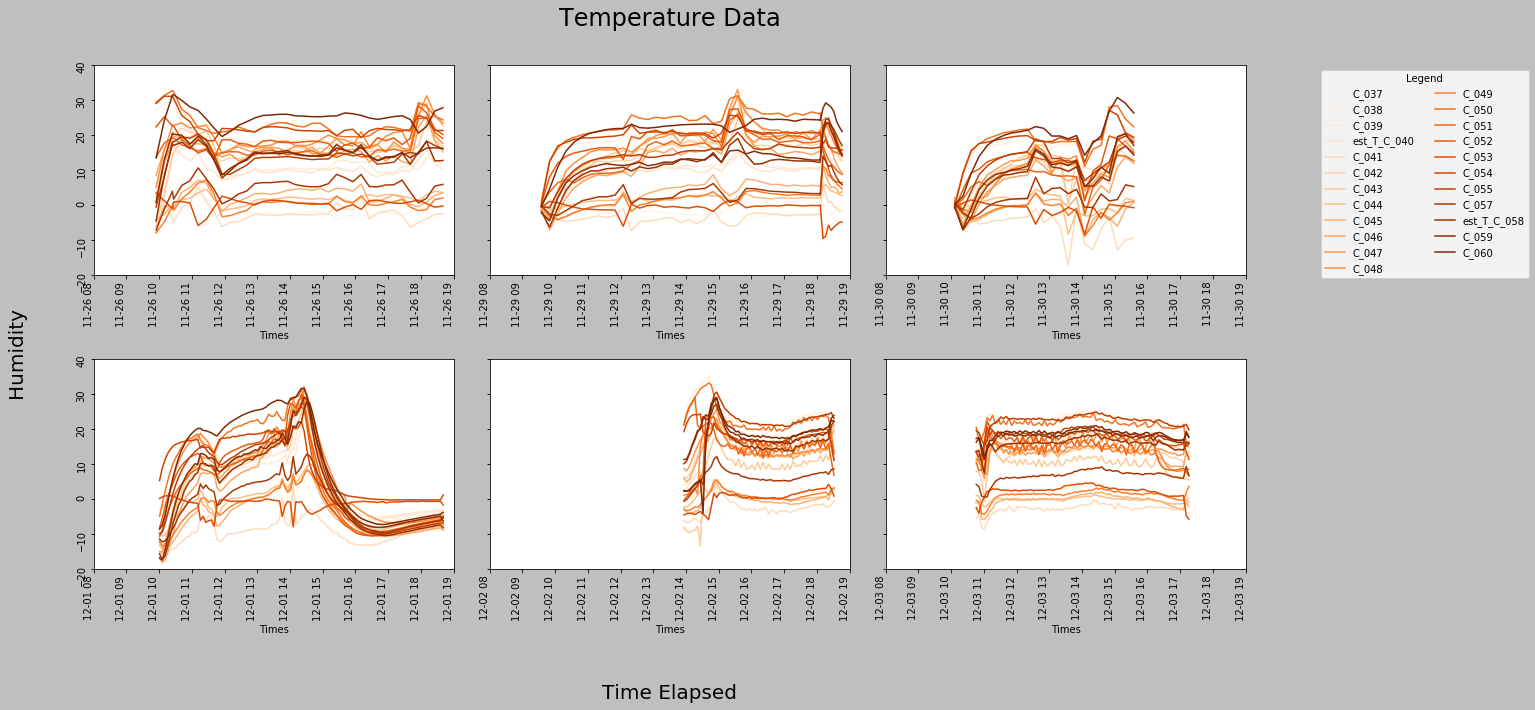

In [16]:
# TEMPERATURE CORRECTED PLOTS
temp_features = ['Times',
                 'C_037', 'C_038', 'C_039', 'est_T_C_040', 'C_041', 'C_042', 'C_043',
       'C_044', 'C_045', 'C_046', 'C_047', 'C_048', 'C_049', 'C_050', 'C_051',
       'C_052', 'C_053', 'C_054', 'C_055', 'C_057', 'est_T_C_058', 'C_059',
       'C_060']
temp_features2 = ['C_037', 'C_038', 'C_039', 'est_T_C_040', 'C_041', 'C_042', 'C_043',
       'C_044', 'C_045', 'C_046', 'C_047', 'C_048', 'C_049', 'C_050', 'C_051',
       'C_052', 'C_053', 'C_054', 'C_055', 'C_057', 'est_T_C_058', 'C_059',
       'C_060']

fig, axes = plt.subplots(2, 3,sharey=True,figsize=(20,10))
plt.style.use('grayscale')
fig = plt.gcf()
all_0[temp_features].plot(kind='line',x='Times',ax=axes[0,0],legend=False,cmap='Oranges')
all_1[temp_features].plot(kind='line',x='Times',ax=axes[0,1],legend=False,cmap='Oranges')
all_2[temp_features].plot(kind='line',x='Times',ax=axes[0,2],legend=False,cmap='Oranges')
all_3[temp_features].plot(kind='line',x='Times',ax=axes[1,0],legend=False,cmap='Oranges')
all_4[temp_features].plot(kind='line',x='Times',ax=axes[1,1],legend=False,cmap='Oranges')
all_5[temp_features].plot(kind='line',x='Times',ax=axes[1,2],legend=False,cmap='Oranges')

axes[0,0].legend(ncol=2,  title="Legend", labels = temp_features2, bbox_to_anchor=(4, 1))
layout = {
    'left'  : 0.1,  
    'right' : 0.9,    
    'bottom' : 0.2,   
    'top' : 0.9,      
    'wspace' : 0.1,   
    'hspace' : 0.4 
    }

plt.subplots_adjust(left=layout['left'], bottom=layout['bottom'], right=layout['right'], top=layout['top'], wspace=layout['wspace'], hspace=layout['hspace'])
fig.suptitle('Temperature Data', fontsize=24)
fig.text(0.5, 0.04, 'Time Elapsed', va='top', ha='center',fontsize=20)
fig.text(0.04, 0.5, 'Humidity', va='center', rotation='vertical',fontsize=20)
plt.ylim(-20,40)
plt.rcParams["date.autoformatter.minute"] = '%H:%M'
plt.rcParams["date.autoformatter.second"] = '%H:%M:%S'
axes[0,0].tick_params(rotation=90)
axes[0,1].tick_params(rotation=90)
axes[0,2].tick_params(rotation=90)
axes[1,0].tick_params(rotation=90)
axes[1,1].tick_params(rotation=90)
axes[1,2].tick_params(rotation=90)
axes[0,0].set_xlim(datetime.datetime(1999,11,26,8), datetime.datetime(1999,11,26,19))
axes[0,1].set_xlim(datetime.datetime(1999,11,29,8), datetime.datetime(1999,11,29,19))
axes[0,2].set_xlim(datetime.datetime(1999,11,30,8), datetime.datetime(1999,11,30,19))
axes[1,0].set_xlim(datetime.datetime(1999,12,1,8), datetime.datetime(1999,12,1,19))
axes[1,1].set_xlim(datetime.datetime(1999,12,2,8), datetime.datetime(1999,12,2,19))
axes[1,2].set_xlim(datetime.datetime(1999,12,3,8), datetime.datetime(1999,12,3,19))
fig.savefig('exp_01_temperature.png')

#### Importing, cleaning and exploring
**Visualizations, Models, Regressions, Classifications** 

My baseline hypothesis is that visualizations would inform design priorities in insulating a shelter.
Two approaches - an animated line plot and a 3D scatter plot have been tested..

All data has been reviewed using subplots and colour coding by sensor.

My next hypothesis is that a heat loss parameter could be estimated from the data.
- my target variable is the parameter that fits the decay curve (and potential all the other curves...)
- my features are all the temperatures and power inputs
There are different documented approaches to this problem: 
- black box: a statistical apporach that finds a transform of some kind
- grey box: a mixture of stats and models of energy conservation (physics concepts) applied to the relationships between variables
- white box: to estimate or test the thermal characteristics of each physical element of the shelter and then simulate these physical characteristics and match the outputs of the (computational fluid dynamics) model to the data

My extension hypothesis is that internal temperatures (or a volume weighted mean) of internal temperatures could be predicted from power input and external temperature.
- my target variables are internal temperature
- my features power input and external temperature


#### Analysing: Exploratory Data Analysis


# ![title](exp_01_humidity.png)

# ![title](exp_01_temperature.png)

### Visualizations

In [ ]:
import matplotlib.dates as dates
import datetime
import matplotlib.patches as patches

In [50]:
sensors_index = pd.read_csv('sensors_index.csv')
sensors_index

hum_sensors = []
air_temp = []
skin_temp = []
hum_sensors_front = []
air_temp_front = []
skin_temp_front = []
hum_sensors_back = []
air_temp_back = []
skin_temp_back = []
for row, col in sensors_index.iterrows():
    if col.type == 'hum' and col.y_slice == 'front':
        hum_sensors_front.append(col.sensor)
    elif col.type == 'hum' and col.y_slice == 'back':
        hum_sensors_back.append(col.sensor)
    elif col.type == 'temp' and col.sensing == 'air' and col.y_slice == 'front':
        air_temp_front.append(col.sensor)
    elif col.type == 'temp' and col.sensing == 'skin' and col.y_slice == 'front':
        skin_temp_front.append(col.sensor)
    elif col.type == 'temp' and col.sensing == 'air' and col.y_slice == 'back':
        air_temp_back.append(col.sensor)
    elif col.type == 'temp' and col.sensing == 'skin' and col.y_slice == 'back':
        skin_temp_back.append(col.sensor)
hum_sensors
air_temp
skin_temp
test_set = sensors_index
test_set2 = test_set.drop('Unnamed: 0',axis=1)
test_set2.head(3)
hum_sensors_front
for row, col in sensors_index.iterrows():
    if col.type == 'hum':
        hum_sensors.append(col.sensor)
    elif col.type == 'temp' and col.sensing == 'air':
        air_temp.append(col.sensor)
    elif col.type == 'temp' and col.sensing == 'skin':
        skin_temp.append(col.sensor)
hum_sensors

print(hum_sensors)
print(air_temp)
print(skin_temp)
print(hum_sensors_front)
print(air_temp_front)
print(skin_temp_front)
print(hum_sensors_back)
print(air_temp_back)
print(skin_temp_back)

['C_021', 'C_022', 'C_023', 'C_024', 'C_026', 'C_027', 'C_028', 'C_029', 'C_030', 'C_031', 'C_032', 'C_033', 'C_034', 'C_035']
['C_037', 'C_038', 'C_041', 'C_042', 'C_045', 'C_046', 'C_047', 'C_049', 'C_050', 'C_053', 'C_054', 'C_057', 'C_059', 'est_T_C_058']
['C_039', 'C_043', 'C_044', 'C_048', 'C_051', 'C_052', 'C_055', 'C_060', 'est_T_C_040']
['C_021', 'C_022', 'C_023', 'C_024', 'C_026', 'C_027', 'C_028']
['C_041', 'C_042', 'C_045', 'C_046', 'C_047', 'C_049', 'C_050']
['C_043', 'C_048', 'C_051', 'C_052']
['C_029', 'C_030', 'C_031', 'C_032', 'C_033', 'C_034', 'C_035']
['C_037', 'C_038', 'C_053', 'C_054', 'C_057', 'C_059', 'est_T_C_058']
['C_039', 'C_055', 'C_060', 'est_T_C_040']


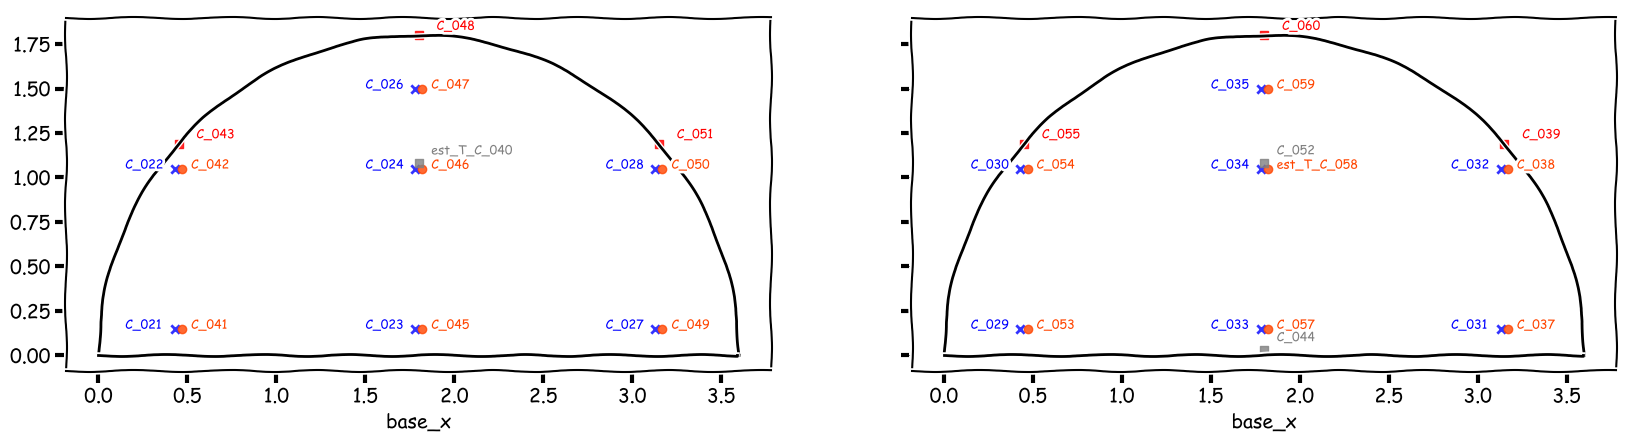

In [46]:
fig, axes = plt.subplots(1, 2,sharey=True,figsize=(20,10))
# create coordinates a semi-circle
x_list = list(np.arange(0, 3.6, 0.01))
x_list.append(3.6)
x = pd.Series(x_list)
#equation of a circle centre (a,0) 
#x**2 – 2*a*x + y**2 = 0
# y**2 = 2*a*x - x**2
# y = np.sqrt(2*a*x - x**2)
y_list = []
for i in x:
    #print(i)
    y_list.append(np.sqrt(2*1.8*i - i**2))
y_list.append(0)
y = pd.Series(y_list)
y
df = pd.DataFrame({'x':x,'y':y})

base_x = list(np.arange(0, 3.6, 0.01))
base_y = [0]*len(base_x)
df2 = pd.DataFrame({'base_x':base_x,'base_y':base_y})
# plot front end of shelter
df.plot(kind='line',x='x',y='y',ax=axes[0],legend=None,c='k')
df2.plot(kind='line',x='base_x',y='base_y',ax=axes[0],legend=None,c='k')
axes[0].set_ylim(0,1.8)
axes[0].set_xlim(0,3.6)

# plot back end of shelter
df.plot(kind='line',x='x',y='y',ax=axes[1],legend=None,c='k')
df2.plot(kind='line',x='base_x',y='base_y',ax=axes[1],legend=None,c='k')
axes[1].set_ylim(0,2)
axes[1].set_xlim(0,4)

for i,s in test_set2[test_set2.sensor.isin(hum_sensors)].iterrows():
#    print(test_set2.y_coord[i])
    if test_set2.y_coord[i] == 0.45:   
        #print(test_set2.y_coord[i])
        x = float(test_set2.x_coord[i])
        z = float(test_set2.z_coord[i])
        n = test_set2.sensor[i]
        axes[0].scatter(x-.02, z, marker='x', color='blue',alpha=0.8)#hum sensors
        axes[0].text((x-.3), (z), s=str(n), fontsize=9,color='blue')
    else:
        x = float(test_set2.x_coord[i])
        z = float(test_set2.z_coord[i])
        n = test_set2.sensor[i]
        axes[1].scatter(x-.02, z, marker='x', color='blue',alpha=0.8)
        axes[1].text((x-.3), (z), s=str(n), fontsize=9,color='blue')

for i,s in test_set2[test_set2.sensor.isin(air_temp)].iterrows():
    #print(test_set2.y_coord[i])
    if test_set2.y_coord[i] == 0.45:   
        x = float(test_set2.x_coord[i])
        z = float(test_set2.z_coord[i])
        n = test_set2.sensor[i]
        axes[0].scatter(x+.02, z, marker='o', color='orangered',alpha=0.8)#air temp sensors
        axes[0].text((x+.07), (z), s=str(n), fontsize=9,color='orangered')
    else:
        x = float(test_set2.x_coord[i])
        z = float(test_set2.z_coord[i])
        n = test_set2.sensor[i]
        axes[1].scatter(x+.02, z, marker='o', color='orangered',alpha=0.8)
        axes[1].text((x+.07), (z), s=str(n), fontsize=9,color='orangered')

for i,s in test_set2[test_set2.sensor.isin(skin_temp)].iterrows():
    #print(test_set2.y_coord[i])
    if test_set2.y_coord[i] == 0.45:   
        x = float(test_set2.x_coord[i])
        z = float(test_set2.z_coord[i])
        n = test_set2.sensor[i]
        axes[0].scatter(x, z, marker='s', color='red',alpha=0.8)#skin sensors
        axes[0].text((x+.1), (z+.03), s=str(n), fontsize=9,color='red')
    elif test_set2.y_coord[i] == 3.15:
        x = float(test_set2.x_coord[i])
        z = float(test_set2.z_coord[i])
        n = test_set2.sensor[i]
        axes[1].scatter(x, z, marker='s', color='red',alpha=0.8)
        axes[1].text((x+.1), (z+.03), s=str(n), fontsize=9,color='red')
    elif test_set2.z_coord[i] == 0 or test_set2.y_coord[i] == 0:
        x = float(test_set2.x_coord[i])
        z = float(test_set2.z_coord[i])
        n = test_set2.sensor[i]
        axes[1].scatter(x, z+.03, marker='s', color='grey',alpha=0.8)
        axes[1].text((x+.07), (z+.08), s=str(n), fontsize=9,color='grey')
    elif test_set2.y_coord[i] == 3.6:
        x = float(test_set2.x_coord[i])
        z = float(test_set2.z_coord[i])
        n = test_set2.sensor[i]
        axes[0].scatter(x, z+.03, marker='s', color='grey',alpha=0.8)
        axes[0].text((x+.07), (z+.08), s=str(n), fontsize=9,color='grey')
axes[0].axis('scaled')
axes[1].axis('scaled')
plt.show()

In [47]:
#construct shelter walls
x_list = list(np.arange(-.01, 3.61, 0.01))
x = pd.Series(x_list).astype(float)
#equation of a circle centre (a,0) 
#x**2 – 2*a*x + y**2 = 0
# y**2 = 2*a*x - x**2
# y = np.sqrt(2*a*x - x**2)
y_list = []
for i in x:
    #print(i)
    y_list.append(np.sqrt(2*1.8*i - i**2))
y_list.append(0)
y = pd.Series(y_list).astype(float)
y
df = pd.DataFrame({'x':x,'y':y})
df.dtypes
#construct shelter floor
base_x = list(np.arange(0, 3.6, 0.01))
base_y = [0]*len(base_x)
df2 = pd.DataFrame({'base_x':base_x,'base_y':base_y})
long_y = list(np.arange(0, 3.6, 0.01))
long_z = [0]*len(long_y)
long_x = [1.8]*len(long_y)
df3 = pd.DataFrame({'long_y':long_y,'long_z':long_z})
df4 = pd.DataFrame({'long_y':long_y,'long_x':long_x})


/Users/KateCrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


Text(0.2,0.5,'Height of Tent')

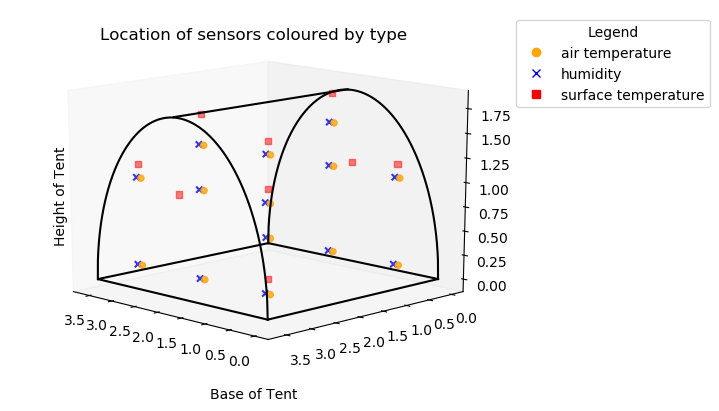

In [24]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Arc, Circle, Ellipse, PathPatch

all_0 = pd.read_csv('clean_exp_1/all_0.csv')

plt.rcdefaults()
#plt.style.use('ggplot')
fig = plt.figure()
ax = plt.axes(projection='3d')

xh = test_set2[test_set2.sensor.isin(hum_sensors)].x_coord.astype(float)
yh = test_set2[test_set2.sensor.isin(hum_sensors)].y_coord.astype(float)
zh = test_set2[test_set2.sensor.isin(hum_sensors)].z_coord.astype(float)
xt = test_set2[test_set2.sensor.isin(air_temp)].x_coord.astype(float)
yt = test_set2[test_set2.sensor.isin(air_temp)].y_coord.astype(float)
zt = test_set2[test_set2.sensor.isin(air_temp)].z_coord.astype(float)
xskin = test_set2[test_set2.sensor.isin(skin_temp)].x_coord.astype(float)
yskin = test_set2[test_set2.sensor.isin(skin_temp)].y_coord.astype(float)
zskin = test_set2[test_set2.sensor.isin(skin_temp)].z_coord.astype(float)

# Data for shelter frame
ax.plot(xs=df.x,ys=df.y,zdir="y",c='k')
ax.plot(xs=df.x,ys=df.y,zs=3.6,zdir="y",c='k')
ax.plot(xs=df2.base_x,ys=df2.base_y,zdir="y",c='k')
ax.plot(xs=df2.base_x,ys=df2.base_y,zs=3.6,zdir="y",c='k')
ax.plot(xs=df3.long_y,ys=df3.long_z,zs=0,zdir="x",c='k')
ax.plot(xs=df3.long_y,ys=df3.long_z,zs=3.6,zdir="x",c='k')
ax.plot(xs=df4.long_y,ys=df4.long_x,zs=1.9,zdir="x",c='k')

# Data for three-dimensional scattered points
ax.scatter3D(xt-.05, yt, zt, marker='o', color='orange',alpha=0.8)
ax.scatter3D(xh+.05, yh, zh, marker='x', color='blue',alpha=0.8)
ax.scatter3D(xskin, yskin, zskin, marker='s', color='red',alpha=0.5)
ax.grid(False)
ax.view_init(elev=15, azim=135)

#labels = ['air temperature', 'humidity', 'surface temperatre']
from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],color='orange', marker='o', label='air temperature',lw=0),
                   Line2D([0],[0],color='blue', marker='x', label='humidity',lw=0),
                   Line2D([0],[0],color='red', marker='s', label='surface temperature',lw=0)]
plt.legend(ncol=1,  title="Legend", handles=legend_elements, bbox_to_anchor=(1, 1))

fig.suptitle('Location of sensors coloured by type',x=0.5,y=.85,fontsize=12)
fig.text(0.5, 0.1, 'Base of Tent', va='top', ha='center',fontsize=10)
fig.text(0.2, 0.5, 'Height of Tent', va='center', ha='center',fontsize=10,rotation=90)
#fig.savefig('exp_01_hum_053D.png')



In [39]:
# data set
d0 = pd.read_csv('clean_exp_1/all_0.csv')
d1 = pd.read_csv('clean_exp_1/all_1.csv')
d2 = pd.read_csv('clean_exp_1/all_2.csv')
d3 = pd.read_csv('clean_exp_1/all_3.csv')
d4 = pd.read_csv('clean_exp_1/all_4.csv')
d5 = pd.read_csv('clean_exp_1/all_5.csv')

d0.Times = pd.to_datetime(d0.Times)
d0 = d0.set_index('Times')
d0 = d0.drop(['Unnamed: 0'],axis=1)

d1.Times = pd.to_datetime(d1.Times)
d1 = d1.set_index('Times')
d1 = d1.drop(['Unnamed: 0'],axis=1)

d2.Times = pd.to_datetime(d2.Times)
d2 = d2.set_index('Times')
d2 = d2.drop(['Unnamed: 0'],axis=1)

d3.Times = pd.to_datetime(d3.Times)
d3 = d3.set_index('Times')
d3 = d3.drop(['Unnamed: 0'],axis=1)

d4.Times = pd.to_datetime(d4.Times)
d4 = d4.set_index('Times')
d4 = d4.drop(['Unnamed: 0'],axis=1)

d5.Times = pd.to_datetime(d5.Times)
d5 = d5.set_index('Times')
d5 = d5.drop(['Unnamed: 0'],axis=1)
print(d0.shape[0])
print(d1.shape[0])
print(d2.shape[0])
print(d3.shape[0])
print(d4.shape[0])
print(d5.shape[0])
air_temp_front

37
44
23
105
56
79


[]

In [51]:
temp_front = sensors_index[(sensors_index.sensor.isin(air_temp_front)) | (sensors_index.sensor.isin(skin_temp_front))]
temp_back = sensors_index[(sensors_index.sensor.isin(air_temp_back)) | (sensors_index.sensor.isin(skin_temp_back))]
hum_front = sensors_index[(sensors_index.sensor.isin(hum_sensors_front)) | (sensors_index.sensor.isin(hum_sensors_front))]
hum_back = sensors_index[(sensors_index.sensor.isin(hum_sensors_back)) | (sensors_index.sensor.isin(hum_sensors_back))]

#temp_front.drop('Unnamed: 0',axis=1,inplace=True)
#temp_back.drop('Unnamed: 0',axis=1,inplace=True)

coords = []
for row, col in temp_front.iterrows():
    coord_pair = []
    x = temp_front.loc[row,'x_coord']
    z = temp_front.loc[row,'z_coord']
    coord_pair.append(x)
    coord_pair.append(z)
    coords.append(coord_pair)
coords
point_data = pd.Series(coords)
point_data = np.array(coords)
point_data

hcoords = []
for row, col in hum_front.iterrows():
    coord_pair = []
    x = hum_front.loc[row,'x_coord']
    z = hum_front.loc[row,'z_coord']
    coord_pair.append(x)
    coord_pair.append(z)
    hcoords.append(coord_pair)
hcoords
hpoint_data = pd.Series(hcoords)
hpoint_data = np.array(hcoords)
hpoint_data
hum_front
hum_sensors_back

calib_hum_front = ['adj_C_021', 'adj_C_022', 'adj_C_023', 'adj_C_024', 'adj_C_026', 'adj_C_027', 'adj_C_028']
calib_hum_back = ['adj_C_029', 'adj_C_030', 'adj_C_031', 'adj_C_032', 'adj_C_033', 'adj_C_034', 'adj_C_035']
calib_hum_front
temp_back


,Unnamed: 0,sensor,type,sensing,y_slice,x_slice,z_slice,v_ref1,v_ref2,v_ref3,x_coord,y_coord,z_coord,slopes,intercepts
16,16,C_037,temp,air,back,right,low,NaN,NaN,NaN,3.15,3.15,0.150000,NaN,NaN
17,17,C_038,temp,air,back,right,middle,NaN,NaN,NaN,3.15,3.15,1.050000,NaN,NaN
18,18,C_039,temp,skin,back,right,side,NaN,NaN,NaN,3.15,3.15,1.190588,NaN,NaN
32,32,C_053,temp,air,back,left,low,NaN,NaN,NaN,0.45,3.15,0.150000,NaN,NaN
33,33,C_054,temp,air,back,left,middle,NaN,NaN,NaN,0.45,3.15,1.050000,NaN,NaN
34,34,C_055,temp,skin,back,left,side,NaN,NaN,NaN,0.45,3.15,1.190588,NaN,NaN
36,36,C_057,temp,air,back,centre,low,NaN,NaN,NaN,1.80,3.15,0.150000,NaN,NaN
38,38,C_059,temp,air,back,centre,high,NaN,NaN,NaN,1.80,3.15,1.500000,NaN,NaN
39,39,C_060,temp,skin,back,centre,roof,NaN,NaN,NaN,1.80,3.15,1.800000,NaN,NaN
40,40,est_T_C_040,temp,skin,back,centre,wall,NaN,NaN,NaN,1.80,3.60,1.050000,NaN,NaN


/Users/KateCrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


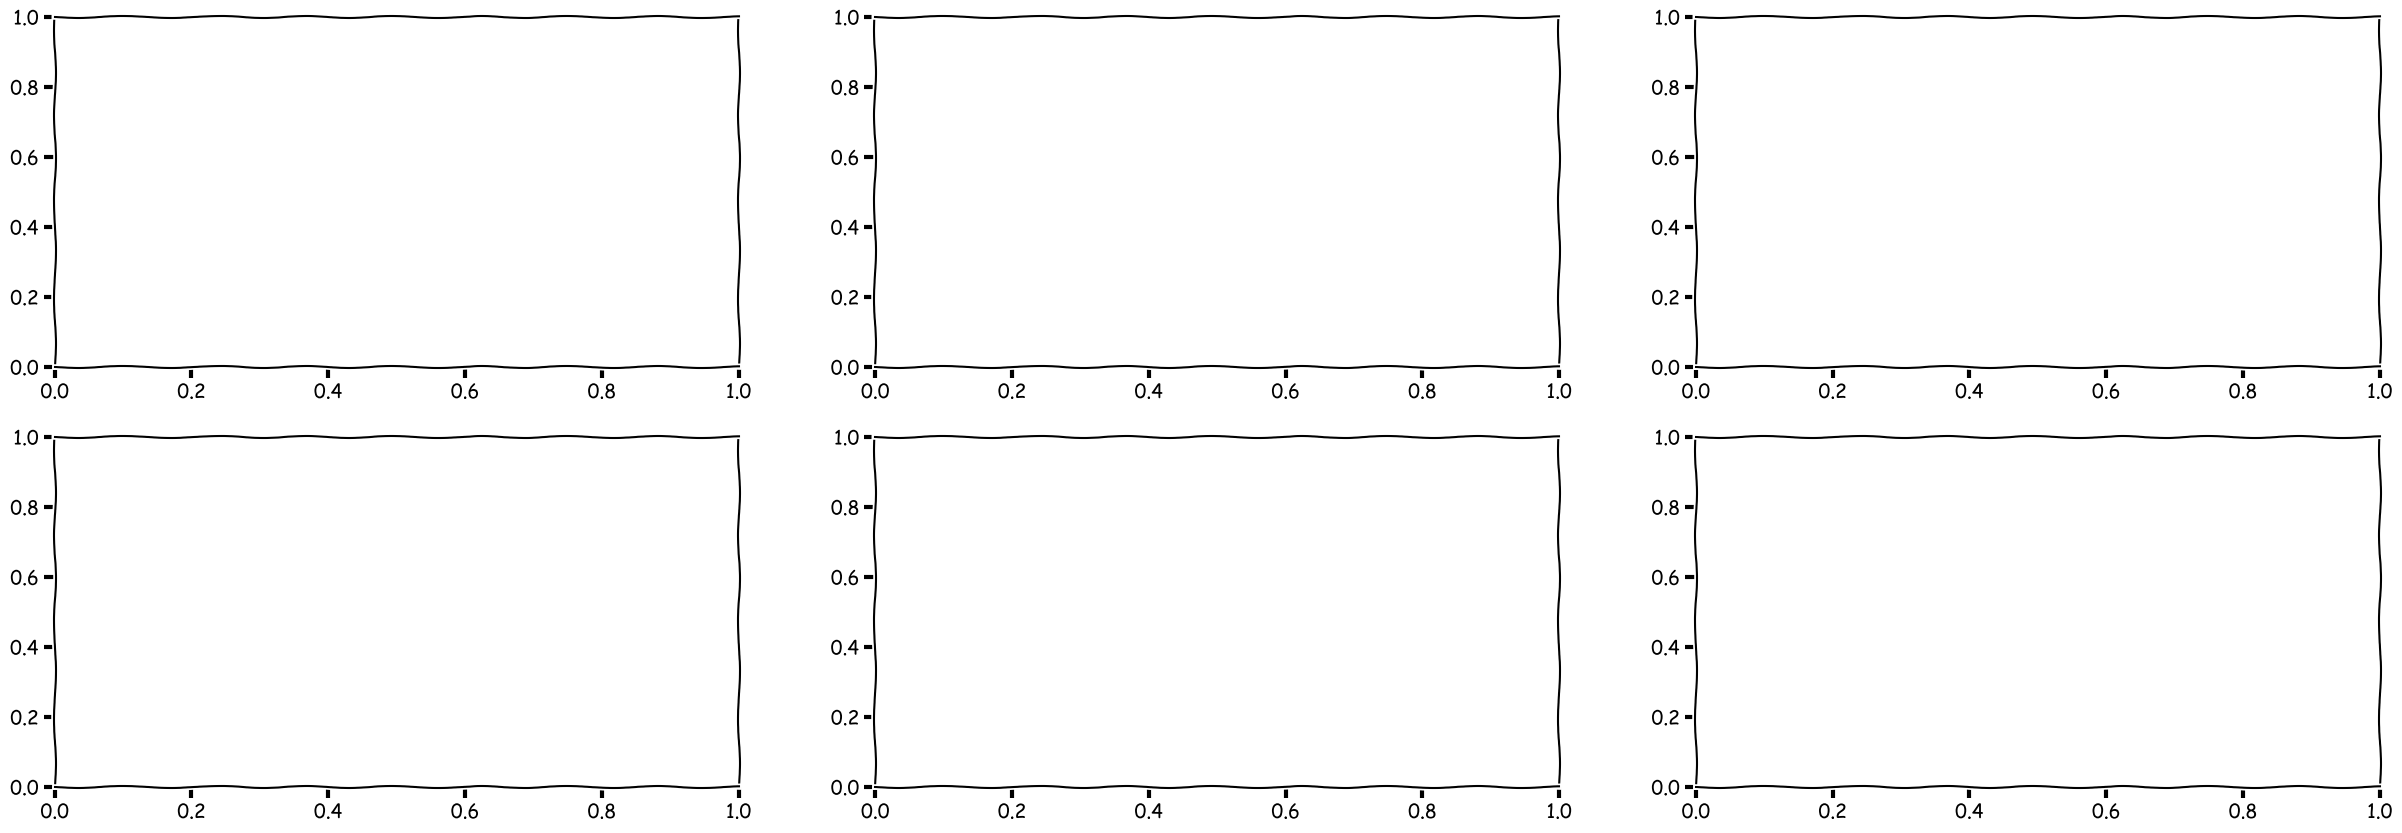

In [52]:
#D0
from scipy.interpolate import griddata
import matplotlib.animation as animation
from scipy.interpolate import griddata
data = d0

xi, yi = np.meshgrid(np.linspace(-.4,4,((4+.4)*20)),np.linspace(0,2,(2*20)))

fig, axes = plt.subplots(2, 3,sharey=False,figsize=(30,10))
plt.xkcd()

def animate(f):
    df = data
    frame = df.index[f]
    # data point coordinates ie x_coord, y_coord
    points = point_data
    hpoints = hpoint_data
    # values at each coord at time, t
    tvalues_front = df.loc[frame,temp_front.sensor]
    tvalues_back = df.loc[frame,temp_back.sensor]
    hvalues_front = df.loc[frame,calib_hum_front]
    hvalues_back = df.loc[frame,calib_hum_back]
    tgrid_front = griddata(points, tvalues_front, (xi, yi), method='nearest')
    tgrid_back = griddata(points, tvalues_back, (xi, yi), method='nearest')
    hgrid_front = griddata(hpoints, hvalues_front, (xi, yi), method='nearest')
    hgrid_back = griddata(hpoints, hvalues_back, (xi, yi), method='nearest')
    tgrid_F = tgrid_front
    for n,m in enumerate(tgrid_F): #n rows, each row containing the array m
        for i in range(0,len(m)): #m-dimension is y, i dimension is x
            value = m[i]
            x = (n * 0.05)
            y = (i * 0.05) - 0.4
            if y >= 3.6 or y < 0:
                tgrid_F[n,i] = -20
            elif x > np.sqrt(2*1.8*y - y**2):
                tgrid_F[n,i] = -20
    tgrid_B = tgrid_back
    for n,m in enumerate(tgrid_B): #n rows, each row containing the array m
        for i in range(0,len(m)): #m-dimension is y, i dimension is x
            value = m[i]
            x = (n * 0.05)
            y = (i * 0.05) - 0.4
            if y >= 3.6 or y < 0:
                tgrid_B[n,i] = -20
            elif x > np.sqrt(2*1.8*y - y**2):
                tgrid_B[n,i] = -20
    hgrid_F = hgrid_front
    for n,m in enumerate(hgrid_F): #n rows, each row containing the array m
        for i in range(0,len(m)): #m-dimension is y, i dimension is x
            value = m[i]
            x = (n * 0.05)
            y = (i * 0.05) - 0.4
            if y >= 3.6 or y < 0:
                hgrid_F[n,i] = 0
            elif x > np.sqrt(2*1.8*y - y**2):
                hgrid_F[n,i] = 0
    hgrid_B = hgrid_back
    for n,m in enumerate(hgrid_B): #n rows, each row containing the array m
        for i in range(0,len(m)): #m-dimension is y, i dimension is x
            value = m[i]
            x = (n * 0.05)
            y = (i * 0.05) - 0.4
            if y >= 3.6 or y < 0:
                hgrid_B[n,i] = 0
            elif x > np.sqrt(2*1.8*y - y**2):
                hgrid_B[n,i] = 0
    sns.scatterplot(x=frame, y=tvalues_front, ax=axes[0,2],color='r')
    sns.scatterplot(x=frame, y=tvalues_back, ax=axes[0,2],color='r')
    sns.scatterplot(x=frame, y=hvalues_front, ax=axes[1,2],color='b')
    sns.scatterplot(x=frame, y=hvalues_back, ax=axes[1,2],color='b')
    axes[0,2].set_xlim('1999-11-26 09:54:35','1999-11-26 18:40:29')
    axes[1,2].set_xlim('1999-11-26 09:54:35','1999-11-26 18:40:29')
    axes[0,2].set_ylim(-20,30)
    axes[1,2].set_ylim(0,100)
    axes[0,2].set_ylabel('Internal Temperatures')
    axes[1,2].set_ylabel('Internal Humidities')
    axes[1,2].set_xlabel('Time Stamp')

    axes[0,0].contourf(xi,yi, tgrid_F,vmin=-20,vmax=30, cmap='Reds')
    axes[0,0].scatter(points[:,0],points[:,1], vmin=-20,vmax=30,c=tvalues_front, cmap='Reds')
    axes[0,1].contourf(xi,yi, tgrid_B,vmin=-20,vmax=30, cmap='Reds')
    axes[0,1].scatter(points[:,0],points[:,1], vmin=-20,vmax=30,c=tvalues_back, cmap='Reds')
    
    axes[1,0].contourf(xi,yi, hgrid_F,vmin=0,vmax=100, cmap='PuBu')
    axes[1,0].scatter(hpoints[:,0],hpoints[:,1], vmin=0,vmax=100,c=hvalues_front, cmap='PuBu')
    axes[1,1].contourf(xi,yi, hgrid_B,vmin=0,vmax=100, cmap='PuBu')
    axes[1,1].scatter(hpoints[:,0],hpoints[:,1], vmin=0,vmax=100,c=hvalues_back, cmap='PuBu')
   
    axes[0,0].axis('scaled')
    axes[0,1].axis('scaled')
    axes[1,0].axis('scaled')
    axes[1,1].axis('scaled')
    axes[0,0].set_ylabel('Shelter Height')
    axes[1,0].set_xlabel('Shelter Width')
    axes[1,0].set_ylabel('Shelter Height')
    axes[1,1].set_xlabel('Shelter Width')

plt.show()

ani = animation.FuncAnimation(fig, animate, np.arange(data.shape[0]), interval=100, repeat=True)
mywriter = animation.FFMpegWriter(fps=5)
ani.save('d0all.mp4',writer=mywriter)

#plt.show()

### Results

In [57]:
results_table = pd.read_csv('results_table.csv', skiprows = 1)
results_table.columns = ['estimate','alternative_fabrics','oxfam_fabrics']
results_table

,estimate,alternative_fabrics,oxfam_fabrics
0,Smean,10.914826,10.141783
1,AWmean,6.306261,5.268284
2,PC_adns_mean,10.950602,10.909053
3,PC_ads_mean,10.496227,8.467736
4,PC_sdns_mean,11.554767,8.912183
5,PC_sds_mean,10.559432,8.917222
6,UA_elements,54.290000,63.820000
7,S_HLC,85.978165,88.183238
8,AW_HLC,101.040583,105.191155
9,PC1_HLC,85.878782,85.994223


#### History of the Data


These tests were carried out in collaboration with Oxfam and a textile manufacturer between 1999 and 2003.


# ![title](images/01_experiments_tents.jpeg)

![title](images/01_experiments_rig.jpeg)

![title](images/02_data_forensics.jpg)

The experimental approach has evolved since these experiments were conducted.


![title](images/04_state_of_the_art.png)

![title](images/03_timeseries.png)

![title](images/04_ctsm.png)

Reference documents and other materials:
https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
